In [1]:
# 📦 Instalação das bibliotecas (Google Colab ou Jupyter Notebook)
!pip install xgboost openpyxl --quiet


In [2]:
# 📚 Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from google.colab import files
from io import BytesIO


In [3]:
# 📁 Upload do arquivo Excel
uploaded = files.upload()
file = next(iter(uploaded))
df = pd.read_excel(BytesIO(uploaded[file]))


Saving OrganizationType_Count_v4_semajust (1)_tratado_v2.xlsx to OrganizationType_Count_v4_semajust (1)_tratado_v2.xlsx


In [4]:
print(df)

     Date Breach  BSF  BSO  BSR  EDU  GOV  MED  NGO  UNKN  Total Geral
0     1990-01-01  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1.0          1.0
1        1997-01  NaN  NaN  NaN  NaN  NaN  1.0  NaN   NaN          1.0
2     1999-09-22  NaN  NaN  NaN  NaN  NaN  1.0  NaN   NaN          1.0
3     2000-01-01  NaN  NaN  NaN  NaN  1.0  NaN  NaN   NaN          1.0
4        2000-05  1.0  NaN  NaN  NaN  NaN  NaN  NaN   NaN          1.0
...          ...  ...  ...  ...  ...  ...  ...  ...   ...          ...
4710  2025-01-22  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1.0          1.0
4711  2025-01-27  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1.0          1.0
4712  2025-01-28  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1.0          1.0
4713  2025-02-03  NaN  NaN  NaN  NaN  NaN  1.0  NaN   NaN          1.0
4714  2025-02-04  NaN  NaN  NaN  NaN  1.0  NaN  NaN   NaN          1.0

[4715 rows x 10 columns]


In [9]:
# ==========================
# Limpeza e preparação
# ==========================
# Remove linha 'UNKN' se existir
# df = df[df['Date Breach'] != 'UNKN'] # This line is causing the error.  'Date Breach' is now the index.

# Since 'Date Breach' is the index, we need to filter it differently:
df = df[df.index != 'UNKN']

# Converte a coluna de data
def ajustar_datas(data_str):
    try:
        if len(data_str) == 4:
            return pd.NaT
        elif len(data_str) == 7:
            return pd.Timestamp(data_str + '-01')     # Ano e mês
        else:
            return pd.Timestamp(data_str)             # Data completa
    except:
        return pd.NaT

# df['Date Breach'] = df['Date Breach'].apply(ajustar_datas) # This line is not needed as 'Date Breach' is the index and we already called ajustar_datas in a previous cell.
# df = df.dropna(subset=['Date Breach'])  # Remove datas inválidas  # This is also not needed as we already called dropna in a previous cell.
# Define o índice como datas (essencial antes do resample)
#df.set_index('Date Breach', inplace=True) # This was already done in a previous cell if 'Date Breach' is the index

# Seleciona colunas por tipo de organização, exceto 'UNKN'
violation_cols = ['BSF', 'BSO', 'BSR', 'EDU', 'GOV', 'MED', 'NGO', 'UNKN', 'Total Geral']
df = df[violation_cols].fillna(0)

# Reamostragem mensal e filtro até 2024
df_monthly = df.resample('ME').sum()
df_filtered = df_monthly[(df_monthly.index >= pd.to_datetime('2010-01-01')) & (df_monthly.index <= pd.to_datetime('2024-12-31'))]



# Essa célula converte as datas, filtra as colunas relevantes, remove nulos e prepara a série para modelagem.

In [15]:
# ✅ Aplicação do modelo XGBoost para cada tipo de violação com MAE e RMSE absolutos
def create_features(df, target_col, lags=12):
    """
    Cria features defasadas (lags) para a coluna alvo.
    """
    df_feat = df.copy()
    for lag in range(1, lags + 1):
        df_feat[f'{target_col}_lag{lag}'] = df_feat[target_col].shift(lag)
    df_feat = df_feat.dropna()
    return df_feat



# ✅ Aplicação do modelo XGBoost para cada tipo de violação com MAE e RMSE absolutos
results = []

for col in df_filtered.columns:
    df_feat = create_features(df_filtered, col, lags=12)
    X = df_feat.drop(columns=[col])
    y = df_feat[col]

    # Divisão treino/teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=24)

    # Treinamento
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan))) * 100

    # Armazena resultados
    results.append({
        'Tipo de Violação': col,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE (%)': round(mape, 2) if not np.isnan(mape) else 'N/A'
    })

# 📊 Mostra os resultados em DataFrame
df_results = pd.DataFrame(results)
df_results


,Tipo de Violação,MAE,RMSE,MAPE (%)
0,BSF,6.53,7.57,38.56
1,BSO,16.92,20.64,28.91
2,BSR,7.63,9.29,132.63
3,EDU,10.17,16.18,39.14
4,GOV,4.28,5.88,70.59
5,MED,11.11,14.26,73.53
6,NGO,4.49,5.76,67.70
7,UNKN,17.45,20.52,38.76
8,Total Geral,42.47,52.00,17.61


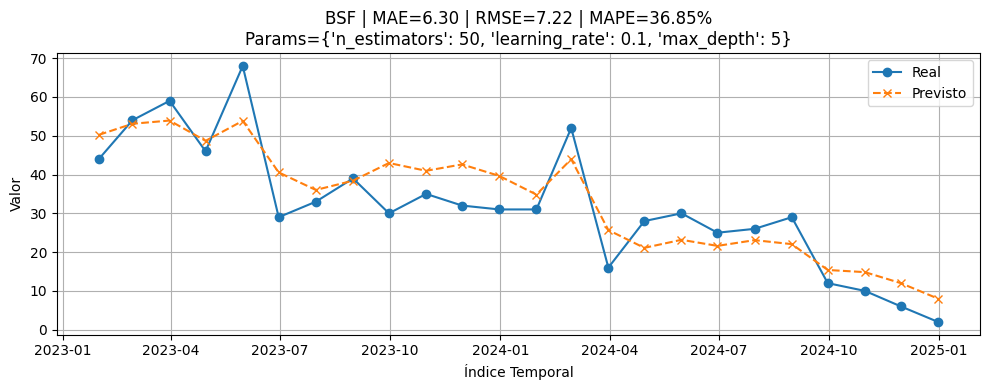

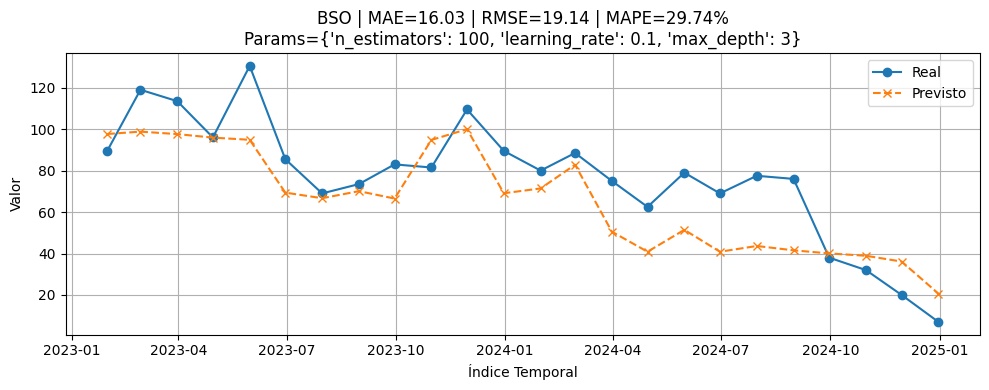

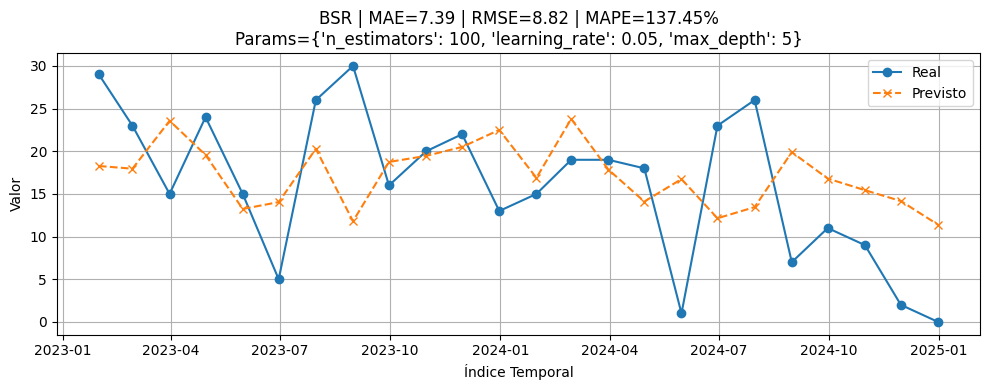

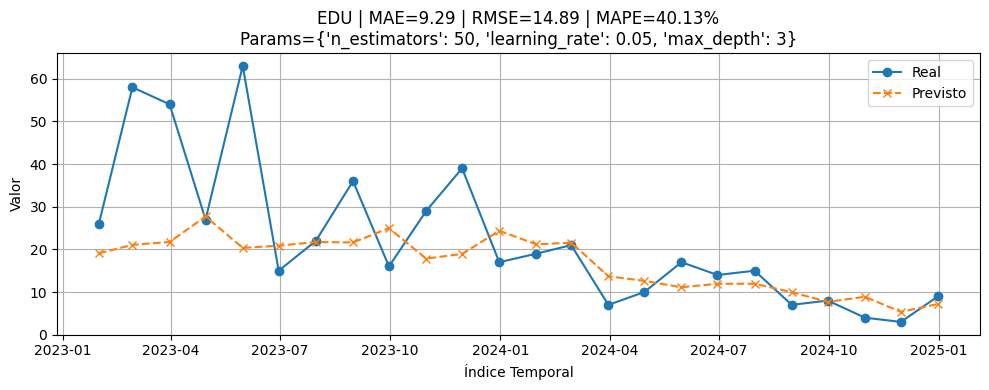

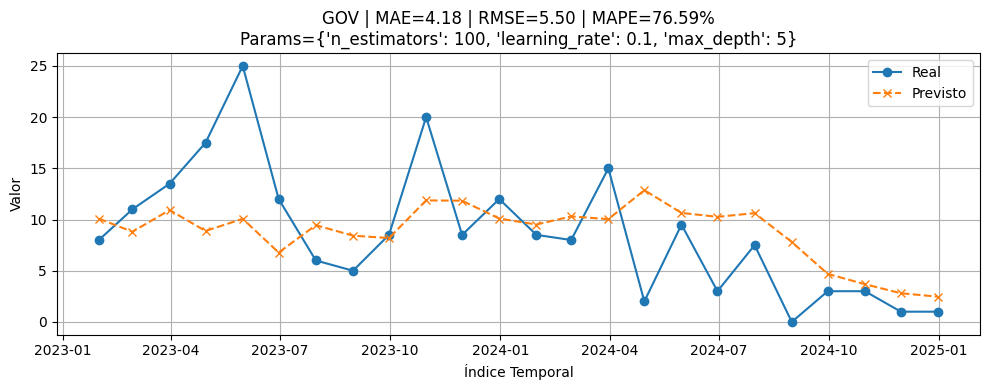

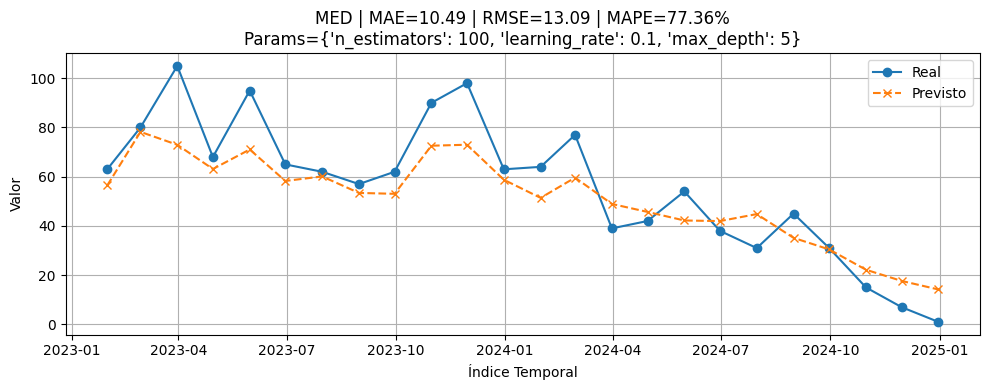

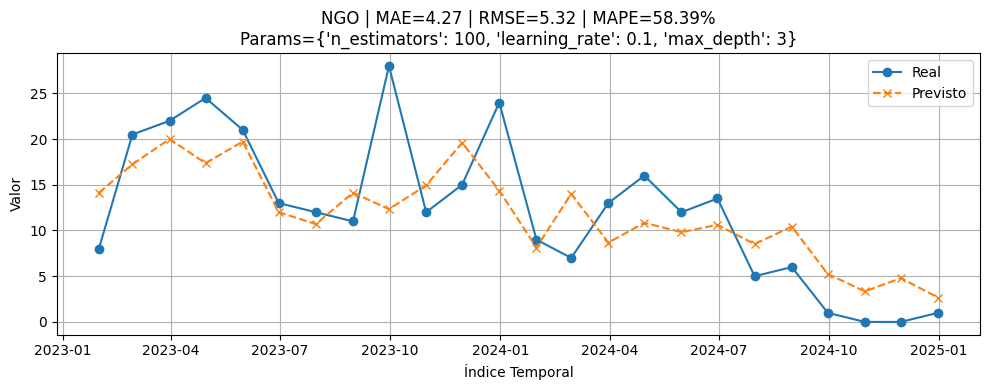

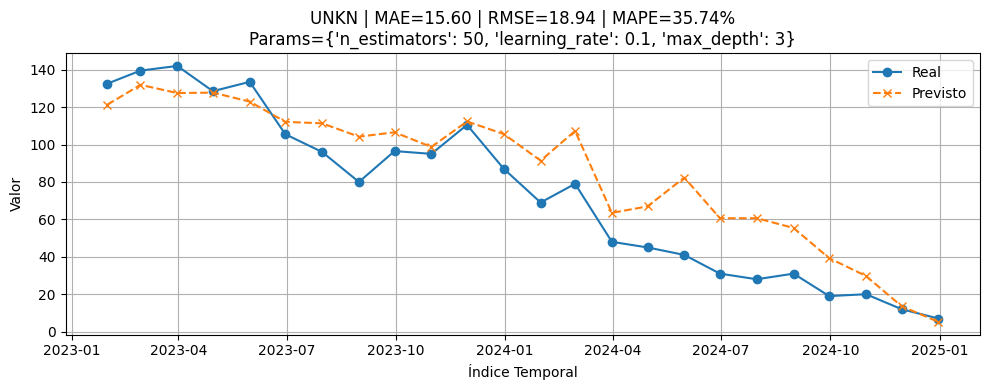

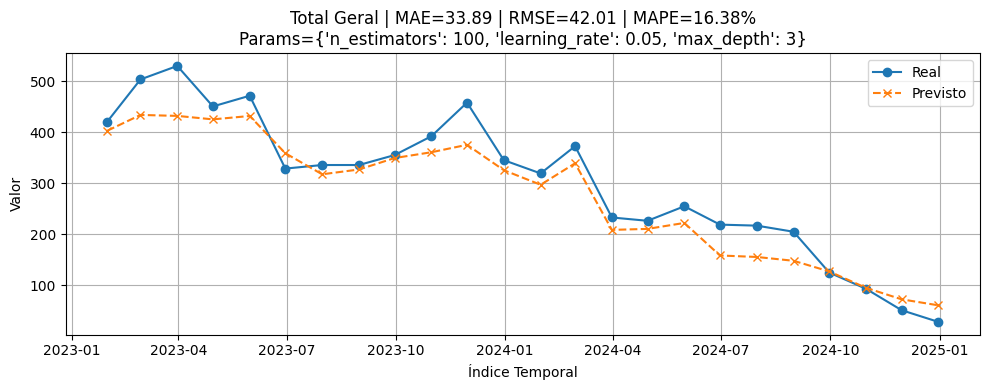

✅ Melhores modelos por violação:
  Tipo de Violação    MAE   RMSE  MAPE (%)  \
0              BSF   6.30   7.22     36.85   
1              BSO  16.03  19.14     29.74   
2              BSR   7.39   8.82    137.45   
3              EDU   9.29  14.89     40.13   
4              GOV   4.18   5.50     76.59   
5              MED  10.49  13.09     77.36   
6              NGO   4.27   5.32     58.39   
7             UNKN  15.60  18.94     35.74   
8      Total Geral  33.89  42.01     16.38   

                                         Best Params  
0  {'n_estimators': 50, 'learning_rate': 0.1, 'ma...  
1  {'n_estimators': 100, 'learning_rate': 0.1, 'm...  
2  {'n_estimators': 100, 'learning_rate': 0.05, '...  
3  {'n_estimators': 50, 'learning_rate': 0.05, 'm...  
4  {'n_estimators': 100, 'learning_rate': 0.1, 'm...  
5  {'n_estimators': 100, 'learning_rate': 0.1, 'm...  
6  {'n_estimators': 100, 'learning_rate': 0.1, 'm...  
7  {'n_estimators': 50, 'learning_rate': 0.1, 'ma...  
8  {'n_esti

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import itertools

# ✅ Criação de features defasadas
def create_features(df, target_col, lags=12):
    df_feat = df.copy()
    for lag in range(1, lags + 1):
        df_feat[f'{target_col}_lag{lag}'] = df_feat[target_col].shift(lag)
    df_feat = df_feat.dropna()
    return df_feat

# ✅ Definição dos hiperparâmetros para Grid Search
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
grid_combinations = list(itertools.product(*param_grid.values()))

# Listas para resultados
results = []
grid_search_results = []

# Loop por coluna
for col in df_filtered.columns:
    df_feat = create_features(df_filtered, col, lags=12)
    if df_feat.empty:
        continue

    X = df_feat.drop(columns=[col])
    y = df_feat[col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=24)

    best_model = None
    best_rmse = np.inf
    best_params = None
    best_y_pred = None

    # 🔍 Grid Search manual
    for params in grid_combinations:
        param_dict = dict(zip(param_grid.keys(), params))
        model = XGBRegressor(random_state=42, **param_dict)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan))) * 100

        # Armazena todos os resultados do grid
        grid_search_results.append({
            'Tipo de Violação': col,
            'n_estimators': param_dict['n_estimators'],
            'learning_rate': param_dict['learning_rate'],
            'max_depth': param_dict['max_depth'],
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'MAPE (%)': round(mape, 2) if not np.isnan(mape) else 'N/A'
        })

        # Atualiza melhor modelo
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = param_dict
            best_y_pred = y_pred

    # Resultado do melhor modelo
    mae = mean_absolute_error(y_test, best_y_pred)
    mape = np.mean(np.abs((y_test - best_y_pred) / y_test.replace(0, np.nan))) * 100

    results.append({
        'Tipo de Violação': col,
        'MAE': round(mae, 2),
        'RMSE': round(best_rmse, 2),
        'MAPE (%)': round(mape, 2) if not np.isnan(mape) else 'N/A',
        'Best Params': best_params
    })

    # Gráfico real vs previsto com melhor modelo
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.index, y_test.values, label='Real', marker='o')
    plt.plot(y_test.index, best_y_pred, label='Previsto', marker='x', linestyle='--')
    plt.title(f'{col} | MAE={mae:.2f} | RMSE={best_rmse:.2f} | MAPE={mape:.2f}%\nParams={best_params}')
    plt.xlabel('Índice Temporal')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 📊 DataFrames finais
df_results = pd.DataFrame(results)
df_gridsearch = pd.DataFrame(grid_search_results)

# Salvar os resultados
df_results.to_csv('melhores_resultados_xgboost.csv', index=False)
df_gridsearch.to_csv('gridsearch_completo_xgboost.csv', index=False)

# Exibir resumo
print("✅ Melhores modelos por violação:")
print(df_results)

print("\n📁 Grid Search completo salvo em 'gridsearch_completo_xgboost.csv'")


Claro! Aqui vai um breve e direto contexto que você pode usar em apresentações, artigos ou defesas:

---

### 📌 **O que é XGBoost?**

**XGBoost (eXtreme Gradient Boosting)** é um algoritmo de aprendizado de máquina baseado em **árvores de decisão** que utiliza a técnica de **boosting por gradiente**. Ele foi projetado para ser:

- **Rápido** e **eficiente**;
- Altamente **preciso**, frequentemente vencendo competições de ciência de dados;
- Capaz de lidar com **grandes volumes de dados**, **valores ausentes**, e **desequilíbrio de classes**.

No contexto de séries temporais, o XGBoost é aplicado após a criação de **features defasadas (lags)**, já que ele não modela a temporalidade diretamente como ARIMA ou LSTM, mas pode aprender **padrões complexos não lineares** ao longo do tempo quando as entradas são preparadas corretamente.

Claro, Evanei! Aqui vai uma explicação clara, técnica e adequada para você apresentar este código em uma **defesa de artigo científico**, especialmente se o foco for a **aplicação de modelos de aprendizado de máquina (XGBoost)** em séries temporais com ajuste de hiperparâmetros via **Grid Search**:

---

## 🎓 **Explicação do Código para Apresentação Científica**

### 🎯 **Objetivo Geral**
O código tem como objetivo aplicar o modelo de aprendizado de máquina **XGBoost Regressor** para prever diferentes **tipos de violações** ao longo do tempo, com base em dados históricos. Cada violação é tratada como uma **série temporal independente**, e o desempenho do modelo é avaliado com base nas métricas **MAE**, **RMSE** e **MAPE**.

Além disso, é realizada uma **busca em grade (Grid Search)** para selecionar os melhores hiperparâmetros para cada série, registrando também os resultados de todas as combinações testadas.

---

### 🧠 **1. Engenharia de Atributos Temporais (Features de Lags)**
```python
def create_features(df, target_col, lags=12):
```
Essa função cria **atributos defasados (lags)** da variável alvo. Isso é essencial para capturar padrões temporais e dependência temporal, permitindo que o modelo "veja o passado" para prever o futuro.

Exemplo: para prever o valor de janeiro, são usadas as observações de dezembro, novembro, etc.

---

### 🧪 **2. Definição do Espaço de Busca (Grid Search Manual)**
```python
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
```
É definido o espaço de busca para os hiperparâmetros do XGBoost:

- `n_estimators`: número de árvores.
- `learning_rate`: taxa de aprendizado.
- `max_depth`: profundidade das árvores.

O uso de `itertools.product` gera todas as combinações possíveis entre os parâmetros.

---

### 🔄 **3. Loop por Série Temporal (Tipo de Violação)**
```python
for col in df_filtered.columns:
```
Cada coluna representa uma série temporal de um tipo de violação. Para cada uma, o modelo é treinado e avaliado **individualmente**, considerando sua própria estrutura temporal.

---

### ⚙️ **4. Treinamento e Avaliação com Grid Search**
```python
model = XGBRegressor(**param_dict)
model.fit(X_train, y_train)
```

- Cada combinação de hiperparâmetros é usada para treinar um modelo.
- O conjunto de **validação temporal** (últimos 24 pontos) é usado para prever e avaliar com as métricas:
  - **MAE** (Erro Absoluto Médio)
  - **RMSE** (Raiz do Erro Quadrático Médio)
  - **MAPE** (Erro Percentual Absoluto Médio)

---

### ✅ **5. Seleção do Melhor Modelo por Violação**
```python
if rmse < best_rmse:
    best_model = model
```
O modelo com o **menor RMSE** é considerado o melhor para aquela série.

---

### 📊 **6. Visualização dos Resultados**
```python
plt.plot(y_test.index, y_test.values, label='Real')
plt.plot(y_test.index, best_y_pred, label='Previsto')
```
Gráficos são gerados para **comparar visualmente o valor real e o previsto**, facilitando a interpretação da performance para cada tipo de violação.

---

### 🗂️ **7. Armazenamento dos Resultados**
Dois DataFrames são criados e exportados:

- `df_results`: contém os **melhores modelos** por tipo de violação e suas métricas.
- `df_gridsearch`: contém **todos os resultados testados** durante o Grid Search, possibilitando análises adicionais como:
  - Avaliação da sensibilidade aos hiperparâmetros.
  - Benchmark entre tipos de violação.

---

### 💡 **Contribuições Científicas Possíveis**
- Mostra a viabilidade da aplicação de **XGBoost com defasagens** em séries temporais não estacionárias.
- Permite identificar quais tipos de violação são mais previsíveis.
- Gera insights de modelagem com base em métricas interpretáveis.
- Permite automatização de tuning com grid search mesmo sem validação cruzada (em respeito à dependência temporal).

---
